# Question 1 Part 2

## Description

Read mandril image, Divide the image into blocks with 64x64 size then find top 10 sharpness block and divid them to 16x16 size also continue this way with 8x8 size then apply dct transform then apply the custom mask, finally apply reverse dct transform and compare the results using mse and psnr method.

## Import required dependencies

- Import cv2 for read and map the color channels
- Import time to timing code speed
- Import numpy to work with arrays
- Import matplotlib to show image for each step

In [21]:
import cv2
import time
import numpy as np
import matplotlib.pyplot as plt

## Read Image

In [22]:
image = cv2.imread("../images/mandril.tiff")

# Convert BGR order to RGB
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

## Define block sizes

In [23]:
block_sizes = [64, 16, 8]

## Define sharpness function

In [24]:
def sharpness(image):
    return cv2.Laplacian(image, cv2.CV_64F).var()

## Define function to divide image into blocks

In [25]:
def devidImage(image, blockSize):
    image_height, image_width, channels = image.shape
    
    image_blocks = np.empty(
        (int(image_height / blockSize), int(image_width / blockSize)),
        dtype=object,
    )

    block_height, block_width = image_blocks.shape

    for i in range(block_width):
        for j in range(block_height):
            image_blocks[j, i] = image[j * blockSize:(j + 1) * blockSize,
                                       i * blockSize:(i + 1) * blockSize, :, ]

    return image_blocks


## Define function to merge image blocks

In [26]:
def mergeBlocks(imageBlocks, image, blockSize):
    result = np.copy(image)

    block_height, block_width = imageBlocks.shape

    for i in range(block_width):
        for j in range(block_height):
            result[j * blockSize:(j + 1) * blockSize,
                   i * blockSize:(i + 1) * blockSize, :, ] = imageBlocks[j, i]

    return result

## Defind mask generator function

In [27]:
def generateMask(blockSize):
    mask = np.zeros((blockSize, blockSize))
    mask[0:int(blockSize/2), 0:int(blockSize/2)] = 1
    return mask

## Defind function to process image

In [28]:
def process(image, block_size_index):
    block_size = block_sizes[block_size_index]

    image_blocks = devidImage(image, block_size)

    image_height, image_width, channels = image.shape
    block_height, block_width = image_blocks.shape

    sharpnesses = np.copy(image_blocks)
    for i in range(block_width):
        for j in range(block_height):
            sharpnesses[j, i] = sharpness(image_blocks[j, i])

    ## find the 10% top sharpness
    target_sharpness = np.sort(sharpnesses.reshape((block_height * block_width)))[::-1][int(block_height * block_width * 0.1)]
    sharpnesses = sharpnesses > target_sharpness

    mask = generateMask(block_size)

    for i in range(block_width):
        for j in range(block_height):
            block = image_blocks[j, i]

            if sharpnesses[j, i]:
                image_blocks[j, i] = process(block, block_size_index + 1)
                continue

            block = np.float32(block) / 255.0
            image_blocks[j, i] = [cv2.dct(block[:, :, x]) for x in range(channels)]

            for c in range(channels):
                image_blocks[j, i][c] = mask * image_blocks[j, i][c]

            image_blocks[j, i] = cv2.merge(
                tuple([cv2.idct(image_blocks[j, i][x]) for x in range(channels)])
            )
            image_blocks[j, i] = np.uint8(image_blocks[j, i] * 255.0)

    return mergeBlocks(image_blocks, image, block_size)

## Define function to compare images with mse and psnr

In [29]:
def mse(image_1, image_2):
    return ((image_1 - image_2) ** 2).sum() / \
        (image_1.shape[0] * image_1.shape[1])

def psnr(image_1, image_2):
    mse_value = mse(image_1, image_2)
    return 10 * np.log((255 ** 2) / mse_value)

def compare(image_1, image_2):
    mse_value = mse(image_1, image_2)
    psnr_value = psnr(image_1, image_2)
    print("MSE: {:.2f} PSNR: {:.2f}".format(mse_value, psnr_value))

## Getting Start

Time: 0.04388284683227539
MSE: 197.30 PSNR: 57.98


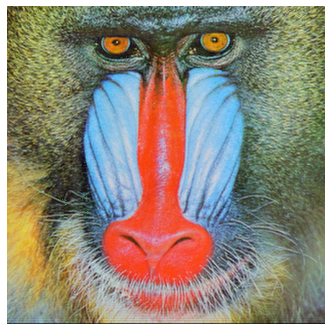

In [30]:
f, subplt = plt.subplots(1,1,figsize=(15,5))
plt.tight_layout()

t0 = time.time()
result = process(image, 0)
t1 = time.time()

print("Time: {}".format(t1 - t0))

compare(image, result)

plt.axis('off')
plt.imshow(result)


## Part 1 result

```
Block Size: 64
Time: 0.02096724510192871
MSE: 197.13 PSNR: 57.99

Block Size: 16
Time: 0.05382728576660156
MSE: 197.93 PSNR: 57.95

Block Size: 8
Time: 0.13263845443725586
MSE: 198.71 PSNR: 57.91
```

As result, according to the results we find out a way to balance code speed and compression rate